In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [2]:
data = pd.read_csv('Kobe.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [3]:
target = 'shot_made_flag'

In [4]:
data[target].isna().sum()

5000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

пропуски есть только в целевой переменной, эти значения используются для предсказания.

In [6]:
data.shape

(30697, 25)

In [7]:
data['team_name'].nunique(), data['team_id'].nunique()

(1, 1)

Колонка team_name содержит только одно уникальное значение, оно не влияет на анализ. Тоже касается team_id. Их удалим.

In [8]:
data['shot_id'].nunique()

30697

Колонка shot_id порядковый номер, тоже не влияет на анализ, удаляем

### визуализируем матрицу корреляции

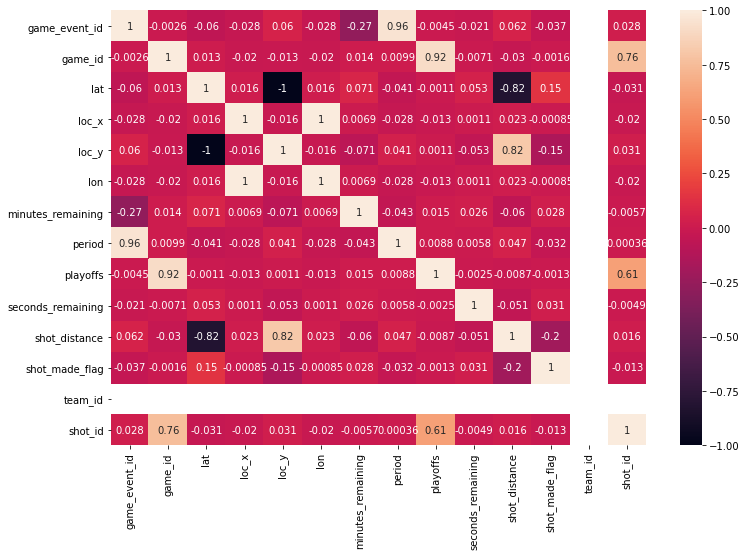

In [9]:
corr = data.corr()
plt.figure(figsize=[12,8])
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

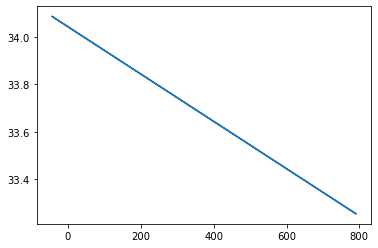

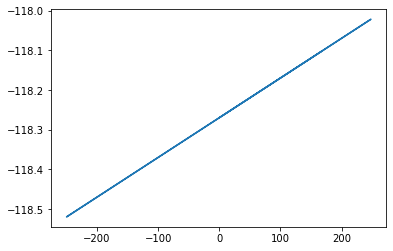

In [10]:
plt.plot(data['loc_y'], data['lat']);
plt.show();
plt.plot(data['loc_x'], data['lon']);

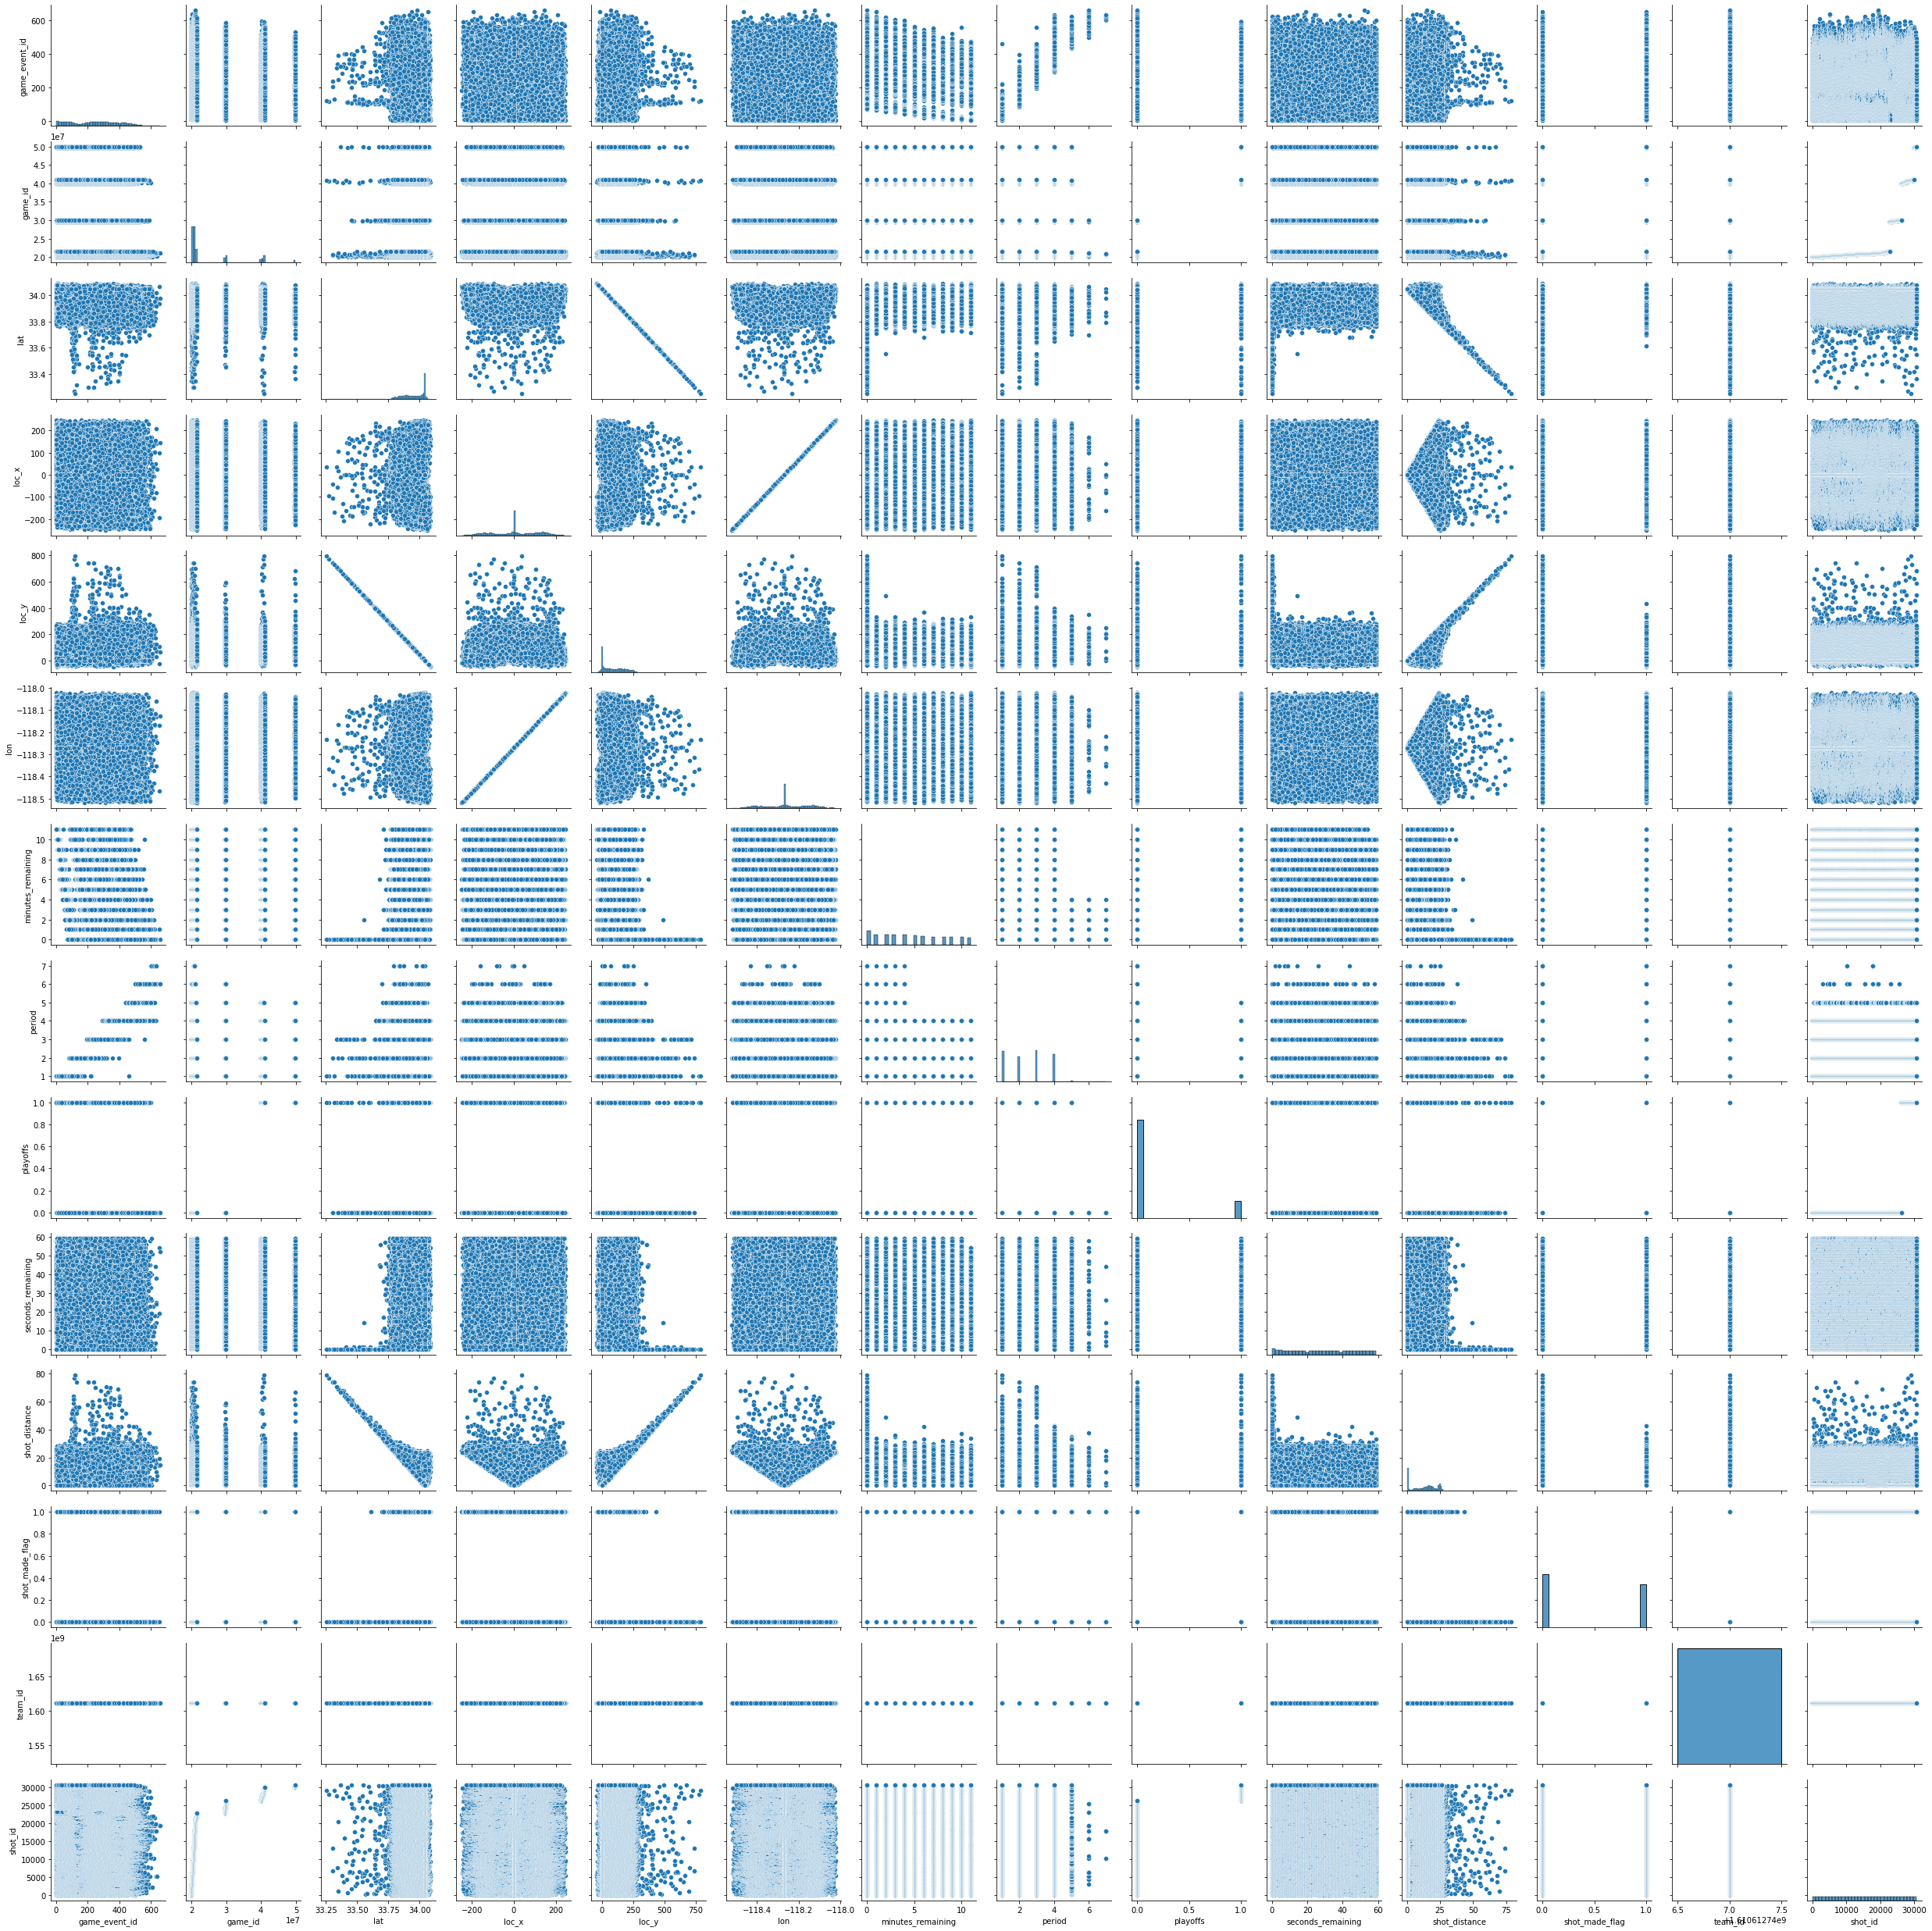

In [11]:
sns.pairplot(data)

Корреляция колонок 'loc_y' и 'lat' равна ровно -1, а корреляция 'loc_x' и 'lon' равна ровно 1

Поэтому удаляем 'loc_y' и 'loc_x'

Посмотрим на дисбаланс в данных

C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


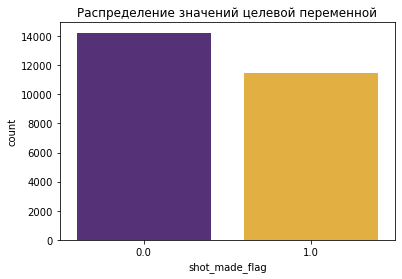

In [12]:
ax = plt.axes()
sns.countplot("shot_made_flag", data=data, ax=ax, palette=("#552583", "#FDB927"))
ax.set_title("Распределение значений целевой переменной")
plt.show()

Дисбаланс целевой переменной невелик, можно оставить как есть

### Обработаем колонку game_date - дата игры, выделим год, месяц, день и день недели

In [13]:
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_year'] = data['game_date'].dt.year
data['game_month'] = data['game_date'].dt.month
data['game_day'] = data['game_date'].dt.day
data['game_dayofweek'] = data['game_date'].dt.dayofweek

In [14]:
# все выделенное из даты трансформируем в строку, потом применим к ним one-hot-encoding
for col in 'game_year', 'game_month', 'game_day', 'game_dayofweek':
    data[col] = data[col].astype('object')

Выделим из колонки matchup игры дома и не дома в бинарном виде.

In [15]:
data["home_play"] = data["matchup"].str.contains("vs").astype("int")

In [16]:
# период делаем с типом object, так как период - порядкое число
data['period'] = data['period'].astype('object')

В данных очень много action types, кодируем редкие action types словом "Other".

In [17]:
pd.DataFrame({"counts": data["action_type"].value_counts().sort_values()[:25]})

,counts
Turnaround Fadeaway Bank Jump Shot,1
Running Slam Dunk Shot,1
Cutting Finger Roll Layup Shot,1
Driving Floating Bank Jump Shot,1
Turnaround Finger Roll Shot,2
Running Tip Shot,2
Putback Slam Dunk Shot,2
Tip Layup Shot,2
Running Finger Roll Shot,4
Running Pull-Up Jump Shot,4


In [18]:
rare_action_types = data["action_type"].value_counts().sort_values().index.values[:20]
data.loc[data["action_type"].isin(rare_action_types), "action_type"] = "Other"

### Удаляем ненужные колонки

Ввиду близкого к нулю значения корреляции game_id и game_event_id с целевой переменной, их стоит удалить, они могут добавлять шум в нашу модель

In [19]:
vars_to_remove = ['team_name', 'shot_id', 'game_date', 'team_id','loc_y', 'loc_x', 'matchup', 'game_id', 'game_event_id']

In [20]:
data.drop(columns=vars_to_remove, inplace=True)
data

,action_type,combined_shot_type,lat,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,game_year,game_month,game_day,game_dayofweek,home_play
0,Jump Shot,Jump Shot,33.9723,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,2000,10,31,1,0
1,Jump Shot,Jump Shot,34.0443,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,2000,10,31,1,0
2,Jump Shot,Jump Shot,33.9093,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,2000,10,31,1,0
3,Jump Shot,Jump Shot,33.8693,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,2000,10,31,1,0
4,Driving Dunk Shot,Dunk,34.0443,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,2000,10,31,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,33.9963,-118.2688,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,IND,2000,6,19,0,1
30693,Tip Shot,Tip Shot,34.0443,-118.2698,6,4,1,1999-00,5,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,IND,2000,6,19,0,1
30694,Running Jump Shot,Jump Shot,33.8783,-118.4038,3,4,1,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,IND,2000,6,19,0,1
30695,Jump Shot,Jump Shot,33.7773,-118.2388,2,4,1,1999-00,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,IND,2000,6,19,0,1


### Находим категориальные признаки

In [21]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
cat_feat

['action_type',
 'combined_shot_type',
 'period',
 'season',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'opponent',
 'game_year',
 'game_month',
 'game_day',
 'game_dayofweek']

In [22]:
# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

action_type           38
combined_shot_type     6
period                 7
season                20
shot_type              2
shot_zone_area         6
shot_zone_basic        7
shot_zone_range        5
opponent              33
game_year             21
game_month             9
game_day              31
game_dayofweek         7
dtype: int64


### Находим непрерывные признаки

In [23]:
num_feat = [f for f in data if f not in (cat_feat)]
num_feat.remove(target)
num_feat

['lat',
 'lon',
 'minutes_remaining',
 'playoffs',
 'seconds_remaining',
 'shot_distance',
 'home_play']

In [24]:
# Смотрим сколько у нас значений по каждому непрерывному признаку
num_nunique = data[num_feat].nunique()
print(num_nunique)

lat                  457
lon                  489
minutes_remaining     12
playoffs               2
seconds_remaining     60
shot_distance         74
home_play              2
dtype: int64


lat


C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


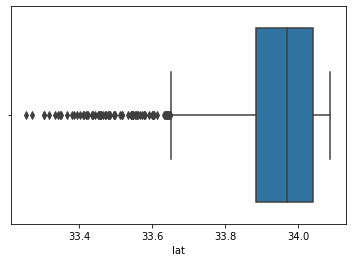

lon


C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


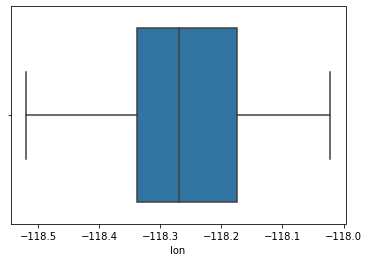

minutes_remaining


C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


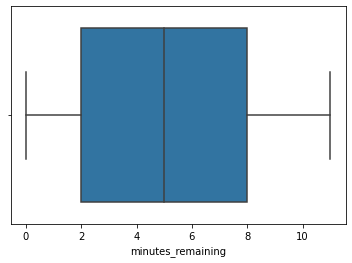

C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


playoffs


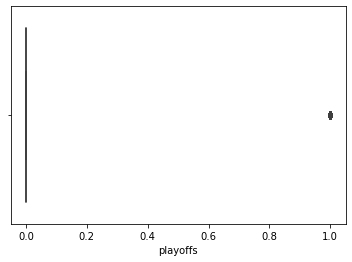

C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


seconds_remaining


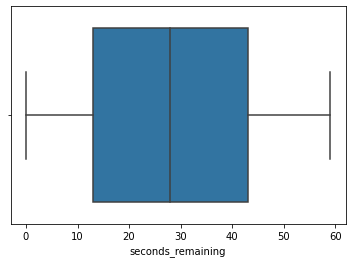

C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


shot_distance


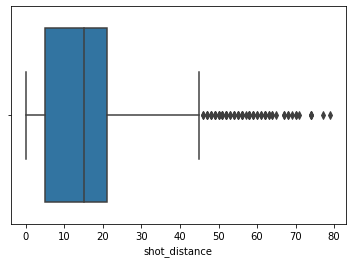

C:\Users\ED-PC\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


home_play


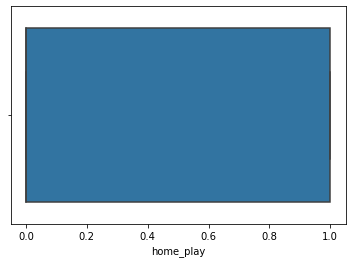

In [25]:
# смотрим выбросы
for col in num_feat:
    print(col)
    sns.boxplot(data[col])
    plt.show()

In [26]:
dummy = pd.get_dummies(data[cat_feat], columns=cat_feat)
dummy.shape

(30697, 192)

In [27]:
data = pd.concat([data[num_feat], dummy, data[target]], axis=1)
data

,lat,lon,minutes_remaining,playoffs,seconds_remaining,shot_distance,home_play,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Other,action_type_Pullup Jump shot,action_type_Putback Layup Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,...,game_year_2015,game_year_2016,game_month_1,game_month_2,game_month_3,game_month_4,game_month_5,game_month_6,game_month_10,game_month_11,game_month_12,game_day_1,game_day_2,game_day_3,game_day_4,game_day_5,game_day_6,game_day_7,game_day_8,game_day_9,game_day_10,game_day_11,game_day_12,game_day_13,game_day_14,game_day_15,game_day_16,game_day_17,game_day_18,game_day_19,game_day_20,game_day_21,game_day_22,game_day_23,game_day_24,game_day_25,game_day_26,game_day_27,game_day_28,game_day_29,game_day_30,game_day_31,game_dayofweek_0,game_dayofweek_1,game_dayofweek_2,game_dayofweek_3,game_dayofweek_4,game_dayofweek_5,game_dayofweek_6,shot_made_flag
0,33.9723,-118.1028,10,0,27,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,NaN
1,34.0443,-118.4268,10,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0
2,33.9093,-118.3708,7,0,45,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0
3,33.8693,-118.1318,6,0,52,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0
4,34.0443,-118.2698,6,0,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,33.9963,-118.2688,6,1,5,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
30693,34.0443,-118.2698,6,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
3069

In [28]:
missing = data[target].isnull()

data_submit = data[missing]
X = data[~missing].drop(target, axis=1)
y = data[target][~missing]

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [31]:
model_logit = LogisticRegression(solver='liblinear')
model_logit.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [32]:
model_logit.score(X_test, y_test)

0.6837107946143669

In [33]:
model_Lasso = Lasso(alpha=0.01)
model_Lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [34]:
model_Ridge = Ridge(alpha=0.01)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=0.01)

In [35]:
df_coeffs = pd.DataFrame({'col': X_train.columns, 'LogisticRegression': model_logit.coef_[0], 'Lasso': model_Lasso.coef_, 'Ridge': model_Ridge.coef_})
df_coeffs

,col,LogisticRegression,Lasso,Ridge
0,lat,-0.239140,-0.000000,0.015939
1,lon,-0.074629,0.000000,-0.214484
2,minutes_remaining,0.014630,0.002026,0.003038
3,playoffs,0.035143,0.000000,0.009306
4,seconds_remaining,0.003970,0.000809,0.000835
...,...,...,...,...
194,game_dayofweek_2,0.068492,0.000000,0.015550
195,game_dayofweek_3,0.025329,0.000000,0.005885
196,game_dayofweek_4,-0.028679,-0.000000,-0.005516
197,game_dayofweek_5,-0.034866,-0.000000,-0.007239


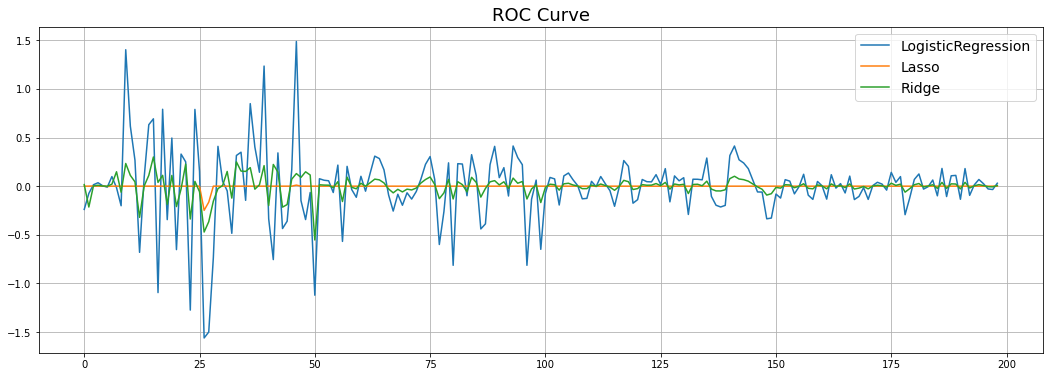

In [36]:
plt.figure(figsize=(18,6))
plt.title("ROC Curve", fontsize=18)
plt.grid()
for col in ['LogisticRegression', 'Lasso', 'Ridge']:
    plt.plot(df_coeffs.index, df_coeffs[col], label=f'{col}')
    plt.legend(fontsize=14)
plt.show()

In [37]:
df_coeffs[df_coeffs['Lasso'] > 0]

,col,LogisticRegression,Lasso,Ridge
2,minutes_remaining,0.014630,0.002026,0.003038
4,seconds_remaining,0.003970,0.000809,0.000835
46,combined_shot_type_Dunk,1.487432,0.010747,0.129219


у модели Lasso практически все коэффициенты занулились, остальные модели не такие категоричные.

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [38]:
from sklearn.metrics import roc_curve, auc

LogisticRegression(solver='liblinear') AUC is 0.66
Lasso(alpha=0.01) AUC is 0.67
Ridge(alpha=0.01) AUC is 0.69


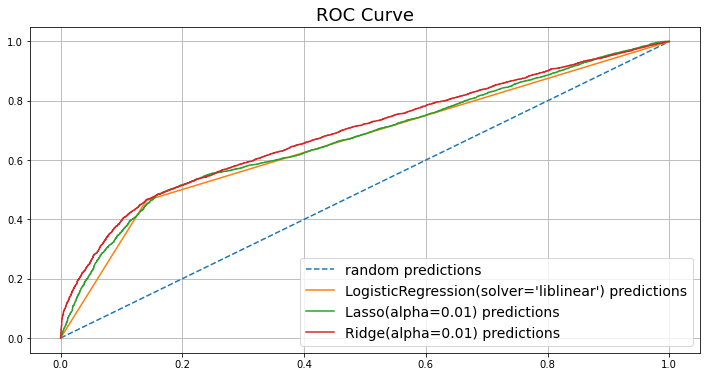

In [39]:
plt.figure(figsize=(12,6))
plt.title("ROC Curve", fontsize=18)
plt.grid()
plt.plot(np.linspace(0,1,100), 
             np.linspace(0,1,100), 
             linestyle='--', 
             label='random predictions')
for model in [model_logit, model_Lasso, model_Ridge]:
    predictions = model.predict(X_test)
    fpr, tpr, thres = roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label=f'{model} predictions')
    plt.legend(fontsize=14)
    print(f"{model} AUC is %.2f" %auc(fpr, tpr))
plt.show()

Судя по ROC кривой все модели имеют приблизительно одинаковое качество

### Построим PCA на подготовленных признаках, 
посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components = 10)
XPCAreduced = pca.fit_transform(np.transpose(X_scaled))

In [41]:
XPCAreduced.shape

(199, 10)

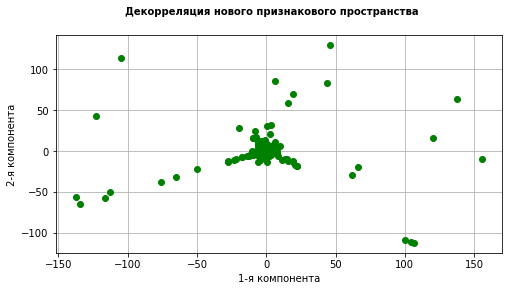

In [42]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.grid(True, which='both')

fig.suptitle('Декорреляция нового признакового пространства', fontsize=10, fontweight='bold')
ax.plot(XPCAreduced[:,0], XPCAreduced[:,1], 'o', color = 'green')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show()

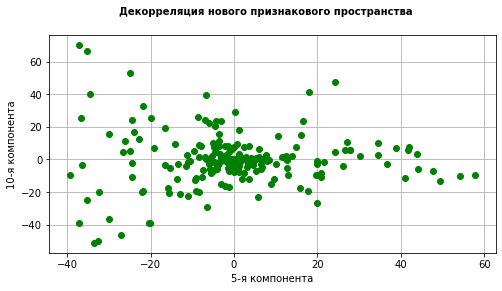

In [43]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.grid(True, which='both')

fig.suptitle('Декорреляция нового признакового пространства', fontsize=10, fontweight='bold')
ax.plot(XPCAreduced[:, 4], XPCAreduced[:, 9], 'o', color = 'green')
plt.xlabel('5-я компонента')
plt.ylabel('10-я компонента')
plt.show()